In [1]:
pip install similaritymeasures

     |████████████████████████████████| 399kB 9.7MB/s 
  Created wheel for similaritymeasures: filename=similaritymeasures-0.4.4-cp37-none-any.whl size=14548 sha256=f0389e759a31c3e2739aebbdca7387e2dd1125288bb12d7c4a3b53f0ac2bd41f
  Stored in directory: /root/.cache/pip/wheels/c0/17/79/b1340175cf3a59d172b03cb9589b2e7933fd700a59d53ac598
Successfully built similaritymeasures


In [2]:
pip install tslearn

     |████████████████████████████████| 798kB 7.1MB/s 


In [3]:
import numpy as np
import glob
import math
import time
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import similaritymeasures
import tslearn
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
import scipy.io

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

In [6]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [7]:
Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data)
Data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


(2858,)

# Choice of datasets

In [8]:
I = np.where(labels == 12)[0] 
J = np.where(labels == 14)[0]
len(I), len(J)

(131, 119)

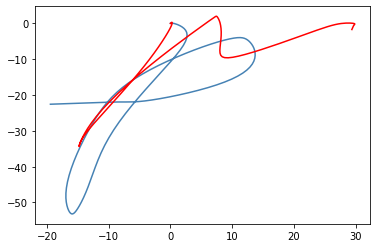

In [9]:
plt.plot(Data[I][-1][:,0], Data[I][-1][:,1], color = "steelblue")
plt.plot(Data[J][-1][:,0], Data[J][-1][:,1], color = "red")
plt.show()

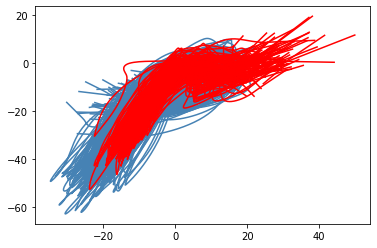

In [10]:
for i in range(len(Data[I])):
  plt.plot(Data[I][i][:,0], Data[I][i][:,1], color = "steelblue")
for i in range(len(Data[J])):
  plt.plot(Data[J][i][:,0], Data[J][i][:,1], color = "red")
plt.show()

In [11]:
data_1 = Data[I]
data_2 = Data[J]
len(data_1), len(data_2)

(131, 119)

# Distances with DTW

In [12]:
def func(A, B):
    C = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(i+1, len(B)):
            C[i][j] = tslearn.metrics.dtw(A[i], B[j])
            C[j][i] = C[i][j]
    return C

def function(a, B):
    C = np.zeros(len(B))
    for i in range(len(B)):
        C[i] = tslearn.metrics.dtw(a, B[i])
    return C

In [ ]:
def KNN_DTW(data_1, data_2):
    
    Start_time = time.time()

    train_1, test_1, y_train_1, y_test_1 = train_test_split(data_1, np.ones(len(data_1)), 
                                                        test_size=0.3, random_state=109)
    train_2, test_2, y_train_2, y_test_2 = train_test_split(data_2, np.ones(len(data_2)), 
                                                        test_size=0.3, random_state=109)

    train_1_labeled = np.concatenate((train_1.reshape(len(train_1), 1), 
                                      np.array([[1]] * len(train_1))), axis =1)
    test_1_labeled = np.concatenate((test_1.reshape(len(test_1), 1), 
                                     np.array([[1]]* len(test_1))), axis =1)
    
    train_2_labeled = np.concatenate((train_2.reshape(len(train_2), 1), 
                                      np.array([[0]] * len(train_2))), axis =1)
    test_2_labeled = np.concatenate((test_2.reshape(len(test_2), 1), 
                                     np.array([[0]]* len(test_2))), axis =1)

 
    train = np.insert(train_1_labeled, len(train_1_labeled), train_2_labeled, axis = 0)
    train = list(train)
    random.shuffle(train)
    train = np.array(train)
    final_train = train[:,0]
    final_train_labels = train[:,1]
    
    test = np.insert(test_1_labeled, len(test_1_labeled), test_2_labeled, axis = 0)
    test = list(test)
    random.shuffle(test)
    test = np.array(test)
    final_test = test[:,0] 
    final_test_labels = test[:,1]

    D_train = func(final_train, final_train)
    
    D_test = np.zeros((len(final_test), len(final_train)))
    for i in range(len(final_test)):
        D_test[i] = function(final_test[i], final_train)

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(final_train_labels))

    #Predict the response for test dataset
    y_pred = clf.predict(D_test)
    test_error = 1 - metrics.accuracy_score(list(final_test_labels), y_pred)

    x_pred = clf.predict(D_train)
    train_error = 1 - metrics.accuracy_score(list(final_train_labels), x_pred)
    
    Dic = {}

    Dic[1] = ["KNN with Dynamic Time Wrapping distance", np.round(train_error, decimals = 4),
              np.round(test_error, decimals = 4)]

    print(pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error']))

    print('total time =', time.time() - Start_time)
    
    return train_error, test_error

In [ ]:
train_error, test_error = KNN_DTW(data_1, data_2)
train_error, test_error

                                Classifier  Train Error  Test Error
1  KNN with Dynamic Time Wrapping distance          0.0         0.0
total time = 35.40181040763855


(0.0, 0.0)

# Distances with Hausdorff distance

In [ ]:
def Hausdorff(u, v):
    a = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return a

In [ ]:
def fun_1(A, B):
    C = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(i+1, len(B)):
            C[i][j] = Hausdorff(A[i], B[j])
            C[j][i] = C[i][j]
    return C

def fun_2(a, B):
    C = np.zeros(len(B))
    for i in range(len(B)):
        C[i] = Hausdorff(a, B[i])
    return C

In [ ]:
def KNN_Hausdorff(data_1, data_2):
    
    Start_time = time.time()

    train_1, test_1, y_train_1, y_test_1 = train_test_split(data_1, np.ones(len(data_1)), 
                                                        test_size=0.3, random_state=109)
    train_2, test_2, y_train_2, y_test_2 = train_test_split(data_2, np.ones(len(data_2)), 
                                                        test_size=0.3, random_state=109)

    train_1_labeled = np.concatenate((train_1.reshape(len(train_1), 1), 
                                      np.array([[1]] * len(train_1))), axis =1)
    test_1_labeled = np.concatenate((test_1.reshape(len(test_1), 1), 
                                     np.array([[1]]* len(test_1))), axis =1)
    
    train_2_labeled = np.concatenate((train_2.reshape(len(train_2), 1), 
                                      np.array([[0]] * len(train_2))), axis =1)
    test_2_labeled = np.concatenate((test_2.reshape(len(test_2), 1), 
                                     np.array([[0]]* len(test_2))), axis =1)

 
    train = np.insert(train_1_labeled, len(train_1_labeled), train_2_labeled, axis = 0)
    train = list(train)
    random.shuffle(train)
    train = np.array(train)
    final_train = train[:,0]
    final_train_labels = train[:,1]
    
    test = np.insert(test_1_labeled, len(test_1_labeled), test_2_labeled, axis = 0)
    test = list(test)
    random.shuffle(test)
    test = np.array(test)
    final_test = test[:,0] 
    final_test_labels = test[:,1]

    D_train = fun_1(final_train, final_train)
    
    D_test = np.zeros((len(final_test), len(final_train)))
    for i in range(len(final_test)):
        D_test[i] = fun_2(final_test[i], final_train)

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(final_train_labels))

    #Predict the response for test dataset
    y_pred = clf.predict(D_test)
    test_error = 1 - metrics.accuracy_score(list(final_test_labels), y_pred)

    x_pred = clf.predict(D_train)
    train_error = 1 - metrics.accuracy_score(list(final_train_labels), x_pred)
    
    Dic = {}

    Dic[1] = ["KNN with discrete Frechet distance", np.round(train_error, decimals = 4),
              np.round(test_error, decimals = 4)]

    print(pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error']))

    print('total time =', time.time() - Start_time)
    
    return train_error, test_error

In [ ]:
train_error, test_error = KNN_Hausdorff(data_1, data_2)

                           Classifier  Train Error  Test Error
1  KNN with discrete Frechet distance       0.0115      0.0132
total time = 29.05680227279663


# Distances with Frechet distance

In [ ]:
def fun1(A, B):
    C = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(i+1, len(B)):
            C[i][j] = similaritymeasures.frechet_dist(A[i], B[j])
            C[j][i] = C[i][j]
    return C

def fun2(a, B):
    C = np.zeros(len(B))
    for i in range(len(B)):
        C[i] = similaritymeasures.frechet_dist(a, B[i])
    return C

In [ ]:
def KNN_discrete_Frechet(data_1, data_2):
    
    Start_time = time.time()

    train_1, test_1, y_train_1, y_test_1 = train_test_split(data_1, np.ones(len(data_1)), 
                                                        test_size=0.3, random_state=109)
    train_2, test_2, y_train_2, y_test_2 = train_test_split(data_2, np.ones(len(data_2)), 
                                                        test_size=0.3, random_state=109)

    train_1_labeled = np.concatenate((train_1.reshape(len(train_1), 1), 
                                      np.array([[1]] * len(train_1))), axis =1)
    test_1_labeled = np.concatenate((test_1.reshape(len(test_1), 1), 
                                     np.array([[1]]* len(test_1))), axis =1)
    
    train_2_labeled = np.concatenate((train_2.reshape(len(train_2), 1), 
                                      np.array([[0]] * len(train_2))), axis =1)
    test_2_labeled = np.concatenate((test_2.reshape(len(test_2), 1), 
                                     np.array([[0]]* len(test_2))), axis =1)

 
    train = np.insert(train_1_labeled, len(train_1_labeled), train_2_labeled, axis = 0)
    train = list(train)
    random.shuffle(train)
    train = np.array(train)
    final_train = train[:,0]
    final_train_labels = train[:,1]
    
    test = np.insert(test_1_labeled, len(test_1_labeled), test_2_labeled, axis = 0)
    test = list(test)
    random.shuffle(test)
    test = np.array(test)
    final_test = test[:,0] 
    final_test_labels = test[:,1]

    D_train = fun1(final_train, final_train)
    
    D_test = np.zeros((len(final_test), len(final_train)))
    for i in range(len(final_test)):
        D_test[i] = fun2(final_test[i], final_train)

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(final_train_labels))

    #Predict the response for test dataset
    y_pred = clf.predict(D_test)
    test_error = 1 - metrics.accuracy_score(list(final_test_labels), y_pred)

    x_pred = clf.predict(D_train)
    train_error = 1 - metrics.accuracy_score(list(final_train_labels), x_pred)
    
    Dic = {}

    Dic[1] = ["KNN with discrete Frechet distance", np.round(train_error, decimals = 4),
              np.round(test_error, decimals = 4)]

    print(pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error']))

    print('total time =', time.time() - Start_time)
    
    return train_error, test_error

In [ ]:
train_error, test_error = KNN_discrete_Frechet(data_1, data_2)

                           Classifier  Train Error  Test Error
1  KNN with discrete Frechet distance       0.0057         0.0
total time = 12924.194776773453


# KNN with $d_Q^{\sigma}$

### Feature Mapping

In [13]:
def dist_signed_point_closed(Q, gamma, sigma): 
    
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > 10e-6)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]])
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) + 10e-6
    
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    x = abs(dist_signed.copy())
    R = (L**2).reshape(-1,1)
# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)
    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-6), dist_signed, d)
    
    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 10e-6)[0]
    J2 = np.array(J2)

    dist_segment_copy = dist_segment.copy()
    dist = abs(dist_segment_copy)


    j = np.argmin(dist, axis =1)

    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]:
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                
                y = LA.norm(gamma[0]-gamma[1]) - LA.norm(gamma[-1] - gamma[-2])
                if y < 0:
                    x = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[-2]-gamma[-1])/LA.norm(gamma[-2]-gamma[-1])
                    z = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[1]-gamma[0])/LA.norm(gamma[1]-gamma[0])
                    q = 2 * gamma[0] - (x + z)/2
                else: 
                    x = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[1]-gamma[0])
                    z = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[-2]-gamma[-1])
                    q = 2 * gamma[0] - (x + z)/2
                sign[k] = np.sign((q-gamma[-1]).dot(w[-1] + w[0]))
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[-1]) < LA.norm(Q[k] - gamma[-2]):
                s = w[-1].dot((Q[k] - gamma[-1])/ LA.norm(Q[k] - gamma[-1]) + 10e-6)
                sign[k] = np.sign(s)
            
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
                    
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))

    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = sign * (1/sigma) * (E.reshape(-1,1) * np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)
  
    return dist_weighted.reshape(len(Q))

In [14]:
def dist_signed_point_unclosed(Q, gamma, sigma): 
    
    h = 10e-8
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]]) 
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) 
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    b = dist_signed + 0
    x = abs(b)
    R = (L**2).reshape(-1,1)

# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)

    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * 2*h, dist_signed, d)

    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 2 * h)[0]
    J2 = np.array(J2, dtype = 'object')
    
    dist_segment_copy = dist_segment + 0
    dist = abs(dist_segment_copy)
    
    dist_from_start_1 = np.sqrt(((Q -p1[0])*(Q -p1[0])).sum(axis =1))
    ds_1 = ((Q -p1[0])*w[0]).sum(axis =1)
    dist_from_start = ds_1 * np.maximum(abs(ds_1), np.sqrt(dist_from_start_1**2 - ds_1**2 + 
                                                        h))/ (dist_from_start_1 + h)

    dist_from_end_1 = np.sqrt(((Q -p2[-1])*(Q -p2[-1])).sum(axis =1))
    de_1 = ((Q -p2[-1])* w[-1]).sum(axis =1)
    dist_from_end = de_1 * np.maximum(abs(de_1), np.sqrt(dist_from_end_1**2 - 
                                                de_1**2 + h))/ (dist_from_end_1+ h)
    
    dist_segment[:,0] = np.where(abs(dist[:,0]- dist_from_start_1)< h**2, 
                                 dist_from_start, dist_segment[:,0]) 
    
    dist_segment[:,-1] = np.where(abs(dist[:,-1]- dist_from_end_1)< h**2, 
                                  dist_from_end, dist_segment[:,-1]) 

    j = np.argmin(dist, axis =1)
    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]: 
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                sign[k] = 1
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[j[k]+1]) < LA.norm(Q[k] - 
                                                                            gamma[j[k]]):
                sign[k] = 1
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))
    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) *
                        np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    return dist_weighted.reshape(len(Q))

In [15]:
def dist_signed_point(Q, gamma, sigma):
    
    if LA.norm(gamma[0]-gamma[-1]) > 10e-6:
        A = dist_signed_point_unclosed(Q, gamma, sigma)
    else: 
        A = dist_signed_point_closed(Q, gamma, sigma)
        
    return A

### Choosing Q

In [16]:
Q = np.array([[-3.24902653e+01,  4.60044218e+01],
       [-1.68353212e+01,  4.43267019e+00],
       [-1.10587361e+02,  2.59348076e+01],
       [ 2.92457830e+01, -3.99858732e+01],
       [ 1.17810639e+01, -7.79407977e+01],
       [ 3.53840384e+01, -1.25123595e-01],
       [ 1.26823738e+02, -1.99258348e+01],
       [ 5.42110442e+01,  3.10153988e+01],
       [ 1.52758301e+00,  3.62917151e+00],
       [-4.62751522e+01, -2.46585474e+00],
       [ 3.25632345e+01, -1.34574254e+01],
       [ 3.96964624e+00,  6.12114622e+00],
       [-4.71061489e+01,  1.78451989e+01],
       [ 3.30163320e+01,  4.06856467e+00],
       [-3.91222051e+01, -4.19573723e+01],
       [-5.90871676e+01,  6.29764287e+01],
       [ 3.21785601e+01,  7.29091697e+01],
       [-4.83503786e+01,  4.61095240e+01],
       [ 2.50696612e+01, -5.74618787e+01],
       [ 8.60611470e+00,  3.69777691e+01]])

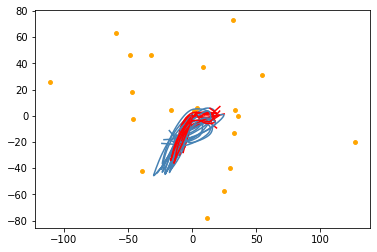

In [17]:
for i in range(30,40):
  plt.plot(Data[I][i][:,0], Data[I][i][:,1], color = "steelblue")
  plt.plot(Data[J][i][:,0], Data[J][i][:,1], color = "red")
plt.scatter(Q[:,0], Q[:,1], s=15, color= 'orange')
plt.show()

In [18]:
len(data_1), len(data_2)

(131, 119)

In [29]:
def KNN(data_1, data_2, sigma, num_iter=10):
    
    Start_time = time.time()
    train_error = np.zeros(num_iter)
    test_error = np.zeros(num_iter)
    
    projected_1 = [0] * len(data_1) 
    projected_2 = [0] * len(data_2)

    for i in range(len(data_1)):
        projected_1[i] = np.concatenate((dist_signed_point_unclosed(Q,data_1[i], sigma),[1]), 
                                        axis = 0)
    for i in range(len(data_2)):
        projected_2[i] = np.concatenate((dist_signed_point_unclosed(Q,data_2[i], sigma),[-1]), 
                                        axis = 0)

    projected_1 = np.array(projected_1)
    projected_2 = np.array(projected_2)

    for i in range(num_iter): 

        R1 = random.sample(range(len(projected_1)), int(0.3 * len(projected_1)))
        R = np.sort(R1)
        R_c = np.sort(list(set(range(len(projected_1))) - set(R)))

        S1 = random.sample(range(len(projected_2)), int(0.3 * len(projected_2)))
        S = np.sort(S1)
        S_c = np.sort(list(set(range(len(projected_2))) - set(S)))

        data_train = np.insert(projected_1[R_c], len(projected_1[R_c]), projected_2[S_c], 
                               axis = 0)
        data_test = np.insert(projected_1[R], len(projected_1[R]), projected_2[S], axis = 0)
        data_train = list(data_train)
        data_test = list(data_test)
        random.shuffle(data_train)
        random.shuffle(data_test)
        data_train = np.array(data_train)
        data_test = np.array(data_test)

        D = np.zeros((len(data_train),len(data_train)))

        for j in range(len(data_train)-1):
            for k in range(j+1, len(data_train)):
                D[j][k] = LA.norm(data_train[j][:-1] - data_train[k][:-1])/math.sqrt(len(Q))
                D[k][j] = D[j][k]

        D_test = np.zeros((len(data_test),len(data_train))) 

        for j in range(len(data_train)):
            for k in range(len(data_test)):
                D_test[k][j] = LA.norm(data_train[j][:-1] - data_test[k][:-1])/math.sqrt(len(Q))

        model = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        #Train the model using the training sets

        model.fit(D, data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(D_test)
        test_error[i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)

        x_pred = model.predict(D)
        train_error[i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)
        
    Dic = {}

    Dic[1] = ["KNN", np.round(np.mean(train_error), decimals = 4), 
                    np.round(np.mean(test_error), decimals = 4),
                   np.round(np.std(test_error), decimals = 4)]

    print(pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                         'Test Error', 'Std Error']))
    print('total time to compute =', time.time() - Start_time)
    
    return np.mean(train_error), np.mean(test_error), np.std(test_error)

In [35]:
train_error, test_error, std = KNN(data_1, data_2, sigma = 50, num_iter=100)

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0215      0.0219     0.0149
total time to compute = 24.491604804992676


# KNN with $d_Q$

In [22]:
def old_dist(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j] 
    
    return dist_weighted.reshape(len(Q)) 

In [23]:
def KNN_old_dist(data_1, data_2, num_iter=10):
    
    Start_time = time.time()
    train_error = np.zeros(num_iter)
    test_error = np.zeros(num_iter)
    
    proj_1 = [0] * len(data_1) 
    proj_2 = [0] * len(data_2)

    for i in range(len(data_1)):
        proj_1[i] = np.concatenate((old_dist(Q,data_1[i]),[1]), axis = 0)
    for i in range(len(data_2)):
        proj_2[i] = np.concatenate((old_dist(Q,data_2[i]),[-1]), axis = 0)

    proj_1 = np.array(proj_1)
    proj_2 = np.array(proj_2)

    for i in range(num_iter): 

        R1 = random.sample(range(len(proj_1)), int(0.3 * len(proj_1)))
        R = np.sort(R1)
        R_c = np.sort(list(set(range(len(proj_1))) - set(R)))

        S1 = random.sample(range(len(proj_2)), int(0.3 * len(proj_2)))
        S = np.sort(S1)
        S_c = np.sort(list(set(range(len(proj_2))) - set(S)))

        data_train = np.insert(proj_1[R_c], len(proj_1[R_c]), proj_2[S_c], 
                               axis = 0)
        data_test = np.insert(proj_1[R], len(proj_1[R]), proj_2[S], axis = 0)
        data_train = list(data_train)
        data_test = list(data_test)
        random.shuffle(data_train)
        random.shuffle(data_test)
        data_train = np.array(data_train)
        data_test = np.array(data_test)

        D = np.zeros((len(data_train),len(data_train)))

        for j in range(len(data_train)-1):
            for k in range(j+1, len(data_train)):
                D[j][k] = LA.norm(data_train[j][:-1] - data_train[k][:-1])/math.sqrt(len(Q))
                D[k][j] = D[j][k]

        D_test = np.zeros((len(data_test),len(data_train))) 

        for j in range(len(data_train)):
            for k in range(len(data_test)):
                D_test[k][j] = LA.norm(data_train[j][:-1] - data_test[k][:-1])/math.sqrt(len(Q))

        model = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        #Train the model using the training sets

        model.fit(D, data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(D_test)
        test_error[i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)

        x_pred = model.predict(D)
        train_error[i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)
        
    Dic = {}

    Dic[1] = ["KNN with d_Q", np.round(np.mean(train_error), decimals = 4), 
                    np.round(np.mean(test_error), decimals = 4),
                   np.round(np.std(test_error), decimals = 4)]

    print(pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                         'Test Error', 'Std Error']))
    print('total time to compute =', time.time() - Start_time)
    
    return np.mean(train_error), np.mean(test_error), np.std(test_error)

In [24]:
train_error, test_error, std = KNN_old_dist(data_1, data_2, num_iter=100)

     Classifier  Train Error  Test Error  Std Error
1  KNN with d_Q       0.0247      0.0405     0.0204
total time to compute = 23.954627513885498
